In [12]:
import torch
import torch.nn as nn # 신경망 계층·활성화·손실 함수 모듈
import torch.optim as optim # SGD, Adam 등 최적화 알고리즘 모듈
from torch.utils.data import DataLoader # 미니배치·셔플·병렬 로딩을 돕는 데이터 로더
from torchvision import datasets, transforms  # 예제 데이터셋(MNIST 등)과 이미지 전처리 툴

from PIL import Image, ImageOps # 이미지 모듈

import numpy as np # 수치 연산을 위한 NumPy
import matplotlib.pyplot as plt # 시각화 도구

In [13]:
# window
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 내 장치가 GPU 인지 CPU 인지 확인

# mac
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # 내 장치가 GPU 인지 CPU 인지 확인

print(f"지금 실행중인 하드웨어 장치 : {device}")

지금 실행중인 하드웨어 장치 : mps


In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),         # PIL → FloatTensor (0~1)
    transforms.Resize((28, 28)),  # 이미지 크기 조정
    transforms.Normalize(mean=(0.5,), std=(0.5,))   # μ, σ = MNIST 통계
])

In [15]:
# root 위치에 train dataset을 저장해라. 불러올때 transform을 적용해서 불러와라
train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
# root 위치에 test dataset을 저장해라. 불러올때 transform을 적용해서 불러와라
test_datset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_datset, batch_size=500, shuffle=False)

In [ ]:
class SmallCNN(nn.Module):
	def __init__(self):
		super(SmallCNN, self).__init__()
		self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) # 28 x 28 -> 28 x 28
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 28 x 28 --> 28 x 28
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 28 x 28 x 64 --> 14 x 14 x 64
		self.fc1 = nn.Linear(64*14*14, 64)
		self.fc2 = nn.Linear(64, 10) # 10 = MNIST의 클래스 개수 (0~9)

	def forward(self, x):
		x = torch.relu(self.conv1(x))
		x = torch.relu(self.conv2(x))
		x = self.pool(x)
		x = x.view(x.size(0),-1) # Flatten the tensor
		x = torch.relu(self.fc1(x))
		x = self.fc2(x)
		return x


In [17]:
model = SmallCNN().to(device)  # 모델을 GPU로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [18]:
def train_one_epoch(epoch):
	model.train()
	running_loss = 0.0
	for x, y in train_loader: # (b,c,h,w)
		x, y = x.to(device), y.to(device) # 데이터를 GPU로 옮김
		optimizer.zero_grad() # 기울기 초기화

		logits = model(x) # Logit(로짓) 함수는 0에서 1까지의 확률값과 -∞에서 ∞ 사이의 확률값을 표현해주는 함수
		loss = criterion(logits, y)
		loss.backward()
		optimizer.step()

		running_loss += loss.item() * x.size(0)

	ave_loss = running_loss / len(train_loader.dataset)
	print(f"Epoch {epoch} | 평균손실 = {ave_loss}")


@torch.no_grad() # 평가 시에는 기울기 계산을 하지 않음
def evaluate():
	model.eval() # 평가 모드로 전환
	correct = 0
	total = 0
	for x, y in test_loader:
		x, y = x.to(device), y.to(device)

		pred = model(x).argmax(dim=1) # 예측값
		correct += (pred == y).sum().item() # 정답과 예측값 비교
		total += y.size(0)

	# 전체 데이터셋에 대한 정확도 계산
	accuracy = correct / total * 100
	print(f"테스트 정확도 = {accuracy:.2f}%")

In [19]:
for epoch in range(10):
	train_one_epoch(epoch)

Epoch 0 | 평균손실 = 0.23675257961203655
Epoch 1 | 평균손실 = 0.054511998914678894
Epoch 2 | 평균손실 = 0.03665350314745058
Epoch 3 | 평균손실 = 0.028620650107910237
Epoch 4 | 평균손실 = 0.020981221137630443
Epoch 5 | 평균손실 = 0.016876443104539066
Epoch 6 | 평균손실 = 0.012443367032318686
Epoch 7 | 평균손실 = 0.009220478794083465
Epoch 8 | 평균손실 = 0.006985700474110975
Epoch 9 | 평균손실 = 0.0045400650400028095


In [20]:
evaluate()  # 평가 함수 호출

테스트 정확도 = 98.84%


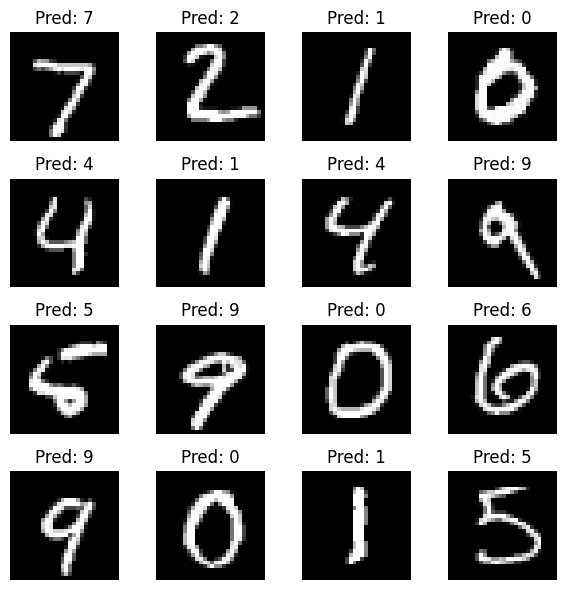

In [ ]:
model.eval()  # 평가 모드로 전환
samples, _= next(iter(test_loader))  # 테스트 데이터셋에서 첫 번째 배치 가져오기
samples = samples[:16].to(device)  # GPU로 이동

with torch.no_grad():
	preds = model(samples).argmax(dim=1).cpu().numpy()  # 예측값을 CPU로 이동하고 NumPy 배열로 변환

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for ax, img, pred in zip(axes.flat, samples.cpu(), preds):
	ax.imshow(img.squeeze(), cmap='gray')  # 이미지 표시
	ax.set_title(f"Pred: {pred}")  # 예측값 표시
	ax.axis('off')  # 축 제거

plt.tight_layout()
plt.show()  # 이미지 출력

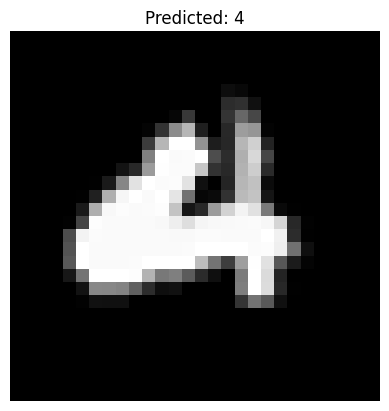

In [22]:
def predict_image(image_path):
	# 이미지 파일을 열고 흑백(L)으로 변환
	image = Image.open(image_path).convert("L")

	# 색상 반전 (MNIST와 유사하게 만들기 위함)
	image = ImageOps.invert(image)

	# 28x28 크기로 리사이즈 (MNIST 입력 크기와 맞춤)
	image = image.resize((28, 28))

	# 시각화를 위한 numpy 배열로 변환 및 정규화
	img_array = np.array(image) / 255.0
	img_array = img_array.reshape(1, 28, 28, 1)

	# 모델 입력을 위한 전처리 (transform 적용 후 배치 차원 추가, device로 이동)
	image = transform(image).unsqueeze(0).to(device)

	# 모델을 평가 모드로 전환 후 예측 수행
	model.eval()
	with torch.no_grad():
		output = model(image).to(device)
		prediction = torch.argmax(output, dim=1).cpu().item()

	# 예측 결과 시각화
	plt.imshow(img_array.squeeze(), cmap='gray')
	plt.title("Predicted: {}".format(prediction))
	plt.axis('off')
	plt.show()

predict_image('test.png')